In [16]:
import seir_discrete 
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

c:\Users\User\anaconda3\envs\conda2\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PolynomialFeatures from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\User\anaconda3\envs\conda2\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\User\anaconda3\envs\conda2\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.1 when using version 1.5.2. This 

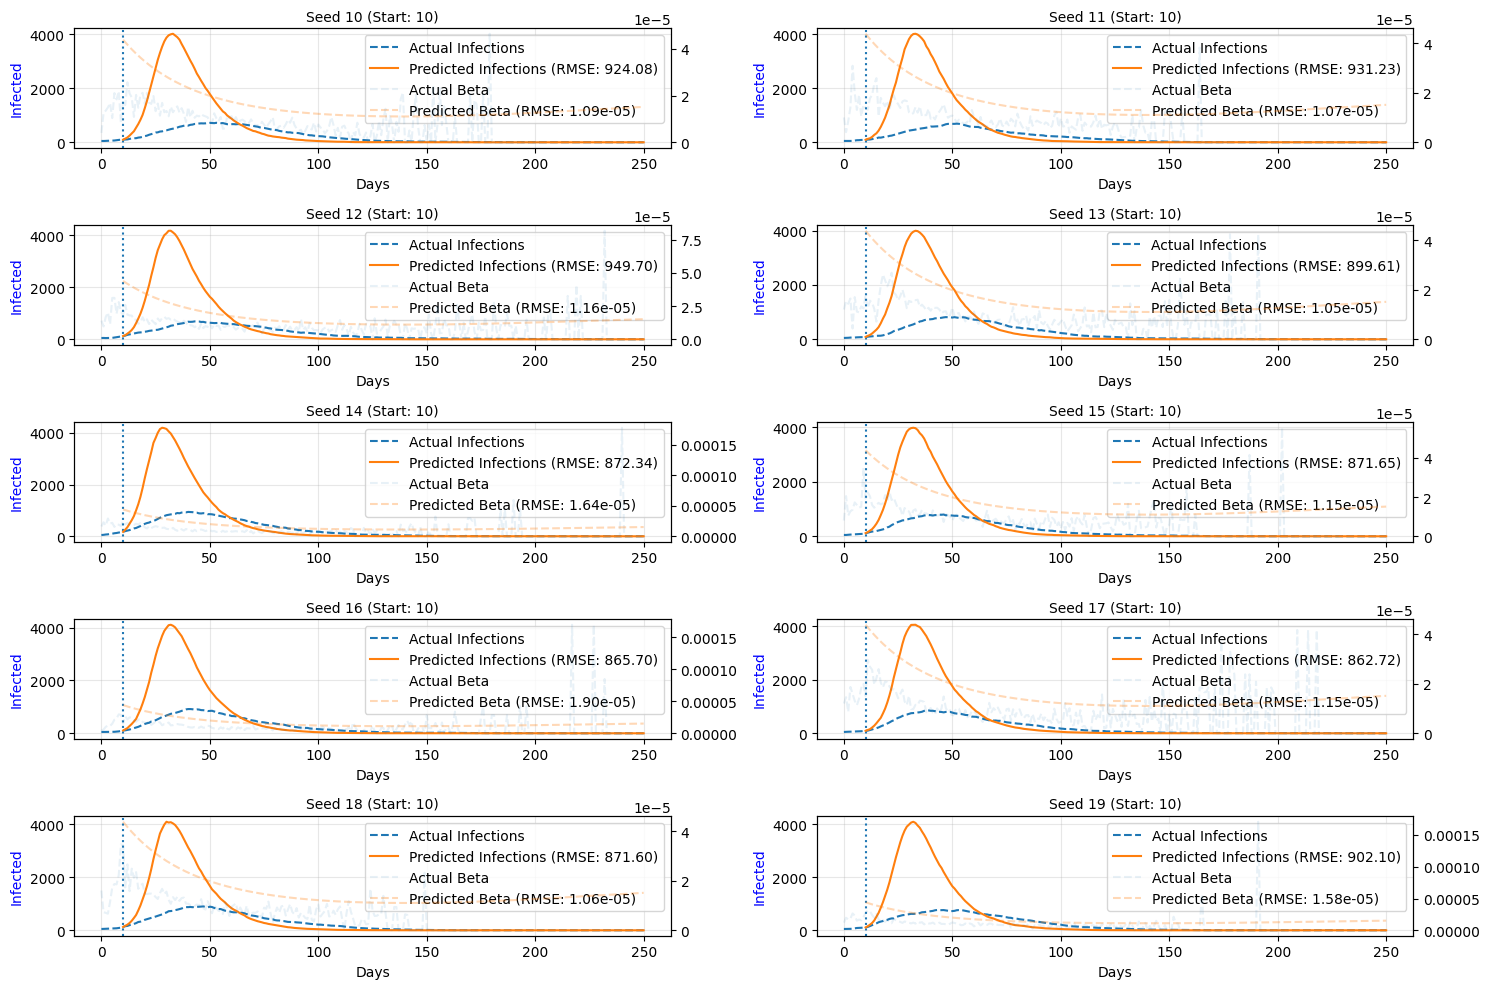

In [17]:

def plot_one(ax, method_type, seed_data, 
             start_day, modeled_I, 
             modeled_beta, modeled_days, seed):
    '''
    Рисуем график для одного сида.
    
    Параметры:
    - ax -- область для графика
    - method_type -- метод прогноза беты
        ['exp_decay', 'polynom', 'percentiles']
    - seed_data -- датафрейм сида от рег.сети
    - start_day -- день переключения на СИИР модель
    - modeled_I -- смоделированный СИИР компартмент Infected
    - modeled_beta -- смоделированная/спрогнозированная бета
    - modeled_days -- дни прогноза
    '''
    
    predicted_I = np.array(modeled_I)
    actual_I = seed_data.iloc[start_day:]['I'].values
    n = len(predicted_I)
    mask_I = ~np.isnan(predicted_I[:n]) & ~np.isnan(actual_I[:n])
    if np.sum(mask_I) > 0:
        rmse_I = np.sqrt(mean_squared_error(actual_I[:n][mask_I], predicted_I[:n][mask_I]))
    else:
        rmse_I = np.nan
        
    # пример:
    # день перехода
    ax.axvline(start_day, ls=':')
    # реальные I, смоделированные I
    ax.plot(seed_data.index, seed_data['I'], ls='--', label='Actual Infections')
    ax.plot(modeled_days, modeled_I,label=f'Predicted Infections (RMSE: {rmse_I:.2f})')
    ax.set_xlabel('Days')
    ax.set_ylabel('Infected', color='blue')
    ax.grid(True, alpha=0.3)

    predicted_Beta = np.array(modeled_beta)
    actual_Beta = seed_data.iloc[start_day:]['Beta'].values
    n_beta = len(predicted_Beta)
    mask_Beta = ~np.isnan(predicted_Beta[:n_beta]) & ~np.isnan(actual_Beta[:n_beta])
    if np.sum(mask_Beta) > 0:
        rmse_Beta = np.sqrt(mean_squared_error(actual_Beta[:n_beta][mask_Beta], predicted_Beta[:n_beta][mask_Beta]))
    else:
        rmse_Beta = np.nan
        
    ax_b = ax.twinx()
    # реальная beta, смоделированная beta
    ax_b.plot(seed_data.index, seed_data['Beta'], ls='--', alpha=0.1, label='Actual Beta')
    ax_b.plot(modeled_days, modeled_beta, ls='--', alpha=0.3,label=f'Predicted Beta (RMSE: {rmse_Beta:.2e})')

    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax_b.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    ax.set_title(f'Seed {seed} (Start: {start_day})', fontsize=10)
    
def load_saved_model(model_path):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")
    return joblib.load(model_path)
    
    
def model_beta(method_type, days):
    '''
    Моделируем/прогнозируем бету.
    Здесь фиксируем время прогноза беты
    '''
    
    if method_type == 'exp_decay':
        # заглушка
        modeled_betas = [0 for i in days]
        
    elif method_type == 'polynom':
        model_path = 'seir_model_barabasi-alber.joblib'
        # загрузка модели с функции ЭлизабЭтти
        model = load_saved_model(model_path)
        # прогнозируем бету на все оставшиеся дни
        log_beta = model.predict(days.reshape(-1,1))
        modeled_betas = np.exp(log_beta)
        
    elif method_type == 'percentiles':
        # заглушка
        modeled_betas = [0 for i in days]
    
    return modeled_betas
        

def main_f(seir_type,stochastic, start_day, method_type='polynom', seeds = np.arange(10,20)):
    '''
    Общая функция для построения графиков.
    
    Параметры:
    - method_type -- метод прогноза беты
        ['exp_decay', 'polynom', 'percentiles']
    - seir_type -- модель СИИР для моделирования траектории Infected
        ['seir', 'sir']
    - stochastic -- модель СИИР стохастическая или нет (детерминированная)
    - seed_dirs -- путь к папке с сидами
    - start_day -- день переключения на СИИР модель
    - seeds -- номера сидов
    
    Выход:
        График на 10 сидов.
    '''
    # всегда постоянные
    sigma = 0.1
    gamma = 0.08
    
    fig, axes = plt.subplots(5, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    seed_dirs=f'{seir_type}_30_seeds_v0/'

    # пока ровно 10 сидов рисуем
    for idx, seed in enumerate(seeds[:10]):
        
        # читаем данные сида: S,[E],I,R,Beta
        seed_data = pd.read_csv(seed_dirs + f'{seir_type}_seed_{seed}.csv')
        # дни для составления прогноза
        modeled_days = np.arange(start_day, seed_data.shape[0])
        # спрогнозированная бета
        modeled_beta = model_beta(method_type, modeled_days)
        # берем значения компартментов в день переключения
        y = seed_data.iloc[start_day].drop('Beta')
    
        # передаем в соответствующую С(И)ИР модель (стохастическую или детерм.)
        # если seir_type == ... , если stochastic == ...
        if seir_type == 'seir':
            if stochastic:
                # пример для seir_type='seir', stype='stochastic'
                res = seir_discrete.seir_model(y, start_day, modeled_days, 
                                    modeled_beta, sigma, gamma, 
                                    stype='stoch', beta_t=True)
                
                # для модели СИР будет: S,I,R = res.T
                S,E,I,R = res.T
            else:
                # пример для seir_type='seir', stype='det'
                res = seir_discrete.seir_model(y, start_day, modeled_days, 
                                    modeled_beta, sigma, gamma, 
                                    stype='det', beta_t=True)
                
                S,E,I,R = res.T
        else:
            if stochastic:
                # пример для seir_type='seir', stype='stochastic'
                res = seir_discrete.sir_model(y, start_day, modeled_days, 
                                    modeled_beta, gamma, 
                                    stype='stoch', beta_t=True)
                
                # для модели СИР будет: S,I,R = res.T
                S,I,R = res.T
            else:
                # пример для seir_type='seir', stype='det'
                res = seir_discrete.sir_model(y, start_day, modeled_days, 
                                    modeled_beta, gamma, 
                                    stype='det', beta_t=True)
                
                # для модели СИР будет: S,I,R = res.T
                S,I,R = res.T
        
        ax = axes[idx]
        # строим один график
        plot_one(ax, method_type, seed_data, 
                start_day, I, modeled_beta,
                    modeled_days, seed)        
    
    plt.tight_layout()
    plt.show()
    
   
stochastic=True
start_day=10    
res = main_f('sir',stochastic, start_day)

    
        